In [ ]:
import pandas as pd
import numpy as np
import os
import ast
import matplotlib.pyplot as plt


# Cargar el archivo de información de participantes
event_df = pd.read_csv("Heart_Rate_VR_Data.csv")  # Archivo con eventos y datos de participantes

In [21]:
def time_to_seconds(time_str):
    """Convierte un tiempo en formato mm:ss a segundos."""
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Convertir la columna de tiempo a segundos
event_df["time"] = event_df["time"].apply(time_to_seconds)


In [22]:
def process_hrv_data(event_df, data_folder, output_file):
    all_events_data = []
    
    for participant_id, participant_data in event_df.groupby("user"):
        file_name = participant_data["hear rate file"].iloc[0]
        sex = participant_data["sex"].iloc[0]
        vr_experience = participant_data["VR experience"].iloc[0]
        heart_vertigo_issue = participant_data["heart/vertigo issue"].iloc[0]
        
        # Cargar el archivo de HRV
        hrv_file_path = os.path.join(data_folder, file_name)
        if not os.path.exists(hrv_file_path):
            print(f"Archivo no encontrado: {hrv_file_path}")
            continue
        
        with open(hrv_file_path, "r") as f:
            hrv_data = [float(line.strip()) for line in f.readlines() if line.strip()]
        
        if not hrv_data:
            print(f"El archivo de HRV está vacío: {hrv_file_path}")
            continue
        
        total_samples = len(hrv_data)
        total_time = participant_data["time"].max()  # El último evento define el tiempo total
        time_per_sample = total_time / total_samples if total_samples > 0 else np.nan
        
        # Obtener eventos con inicio y fin
        participant_data = participant_data.sort_values(by="time")
        event_times = participant_data["time"].values
        event_names = participant_data["event"].values
        fear_levels = participant_data["fear level"].values
        
        for i in range(len(event_names) - 1):
            event_name = event_names[i]
            event_start = event_times[i]
            event_end = event_times[i + 1]  # El evento termina cuando empieza el siguiente
            fear_level = fear_levels[i]
            
            start_idx = int(event_start / time_per_sample)
            end_idx = int(event_end / time_per_sample)
            
            event_hrv_data = hrv_data[start_idx:end_idx] if total_samples > 0 else []
            
            # Guardar datos en lista para dataframe
            all_events_data.append({
                "Nombre": participant_id,
                "Sexo": sex,
                "Experiencia_VR": vr_experience,
                "Problemas_Cardiacos/Vértigo": heart_vertigo_issue,
                "Evento": event_name,
                "Tiempo_Inicio": event_start,
                "Tiempo_Fin": event_end,
                "Nivel_Miedo": fear_level,
                "HRV_Muestras": event_hrv_data  # Guardar todas las muestras en una lista
            })
    
    # Convertir a DataFrame y guardar en CSV
    events_df = pd.DataFrame(all_events_data)
    events_df.to_csv(output_file, index=False)
    print(f"Datos guardados en {output_file}")
    return events_df if not events_df.empty else pd.DataFrame()



In [31]:
# Llamar a la función con la ruta de los archivos TXT y el nombre del CSV final
events_df = process_hrv_data(event_df, "files", "eventos_hrv.csv")

Datos guardados en eventos_hrv.csv


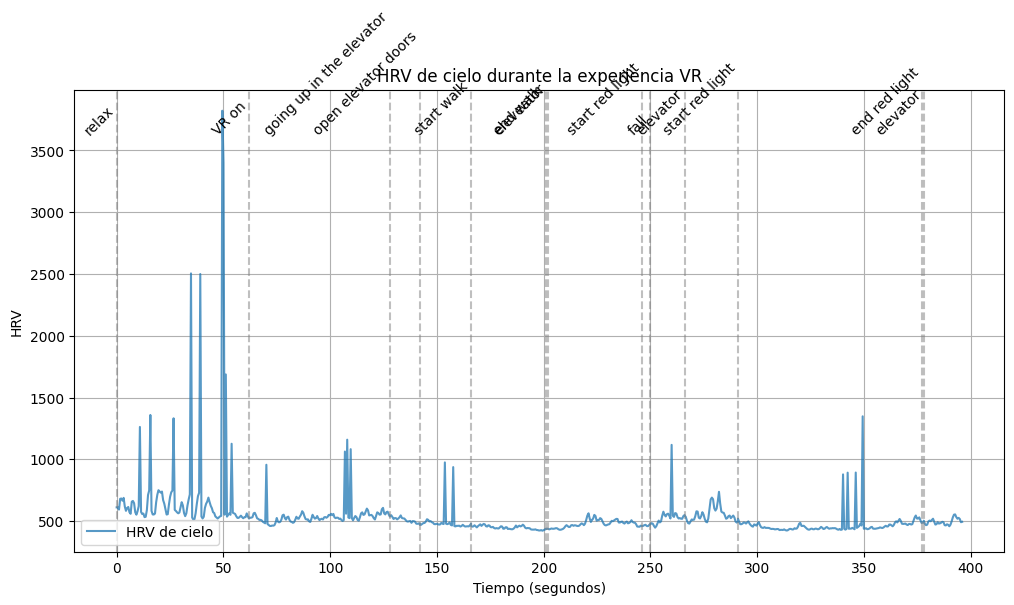

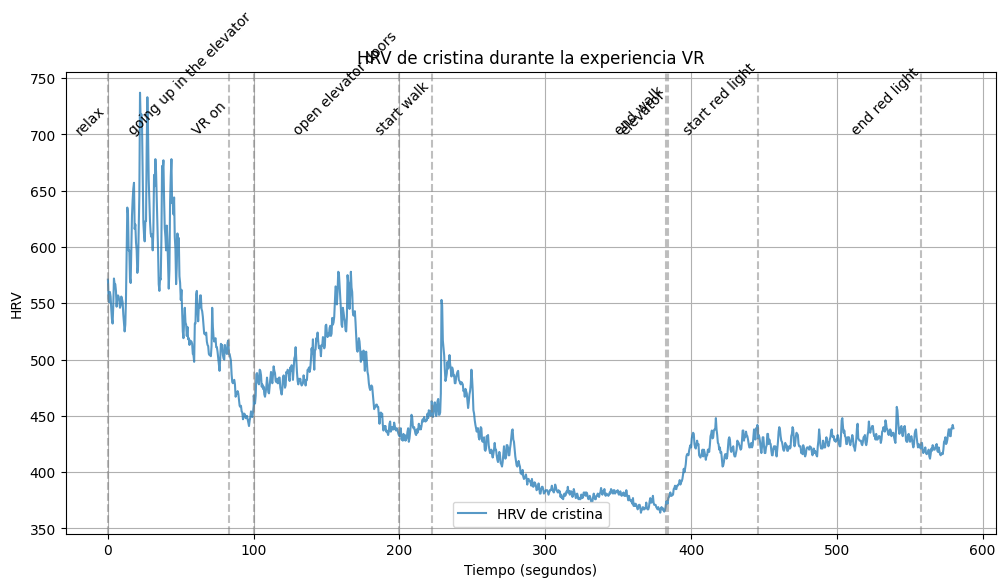

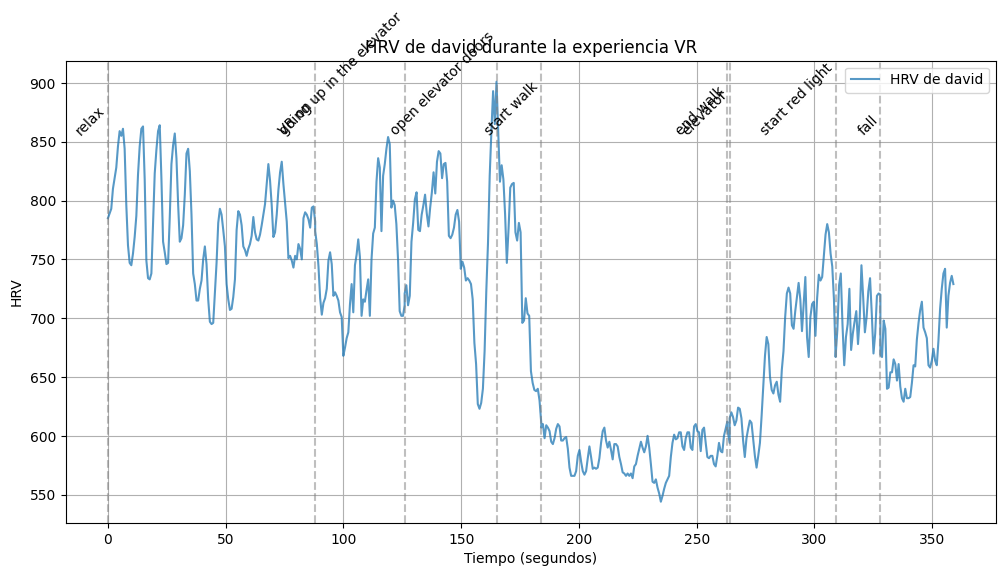

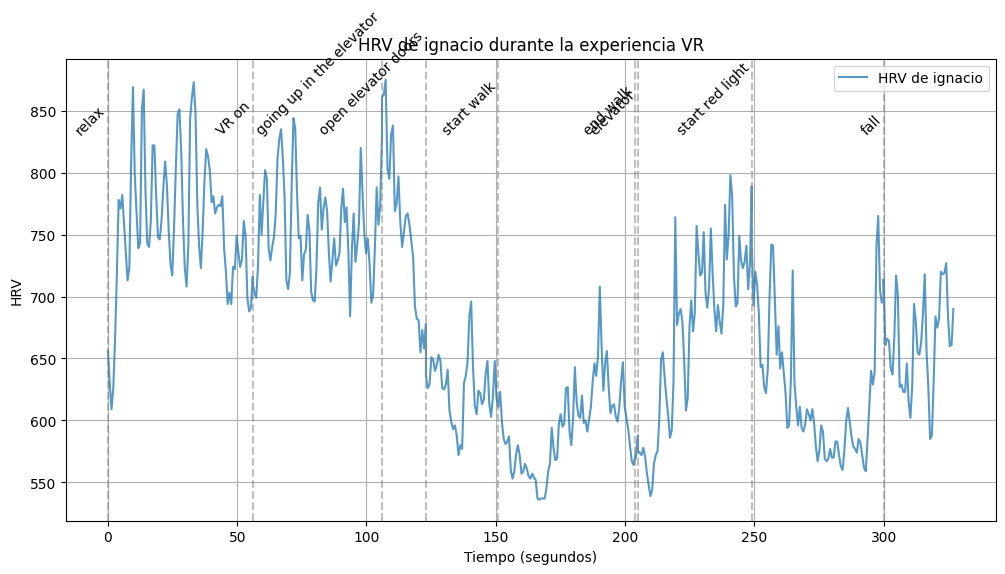

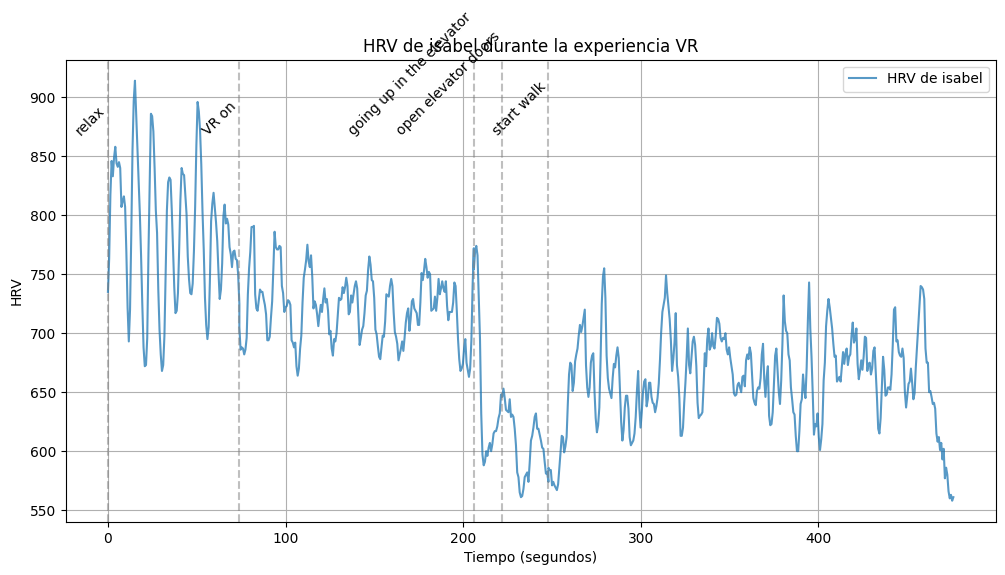

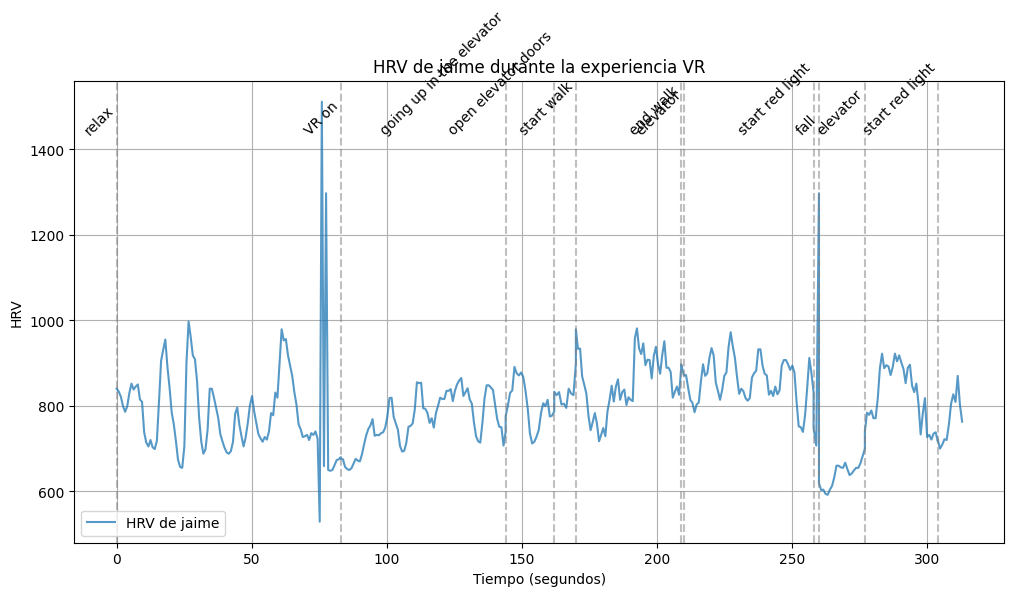

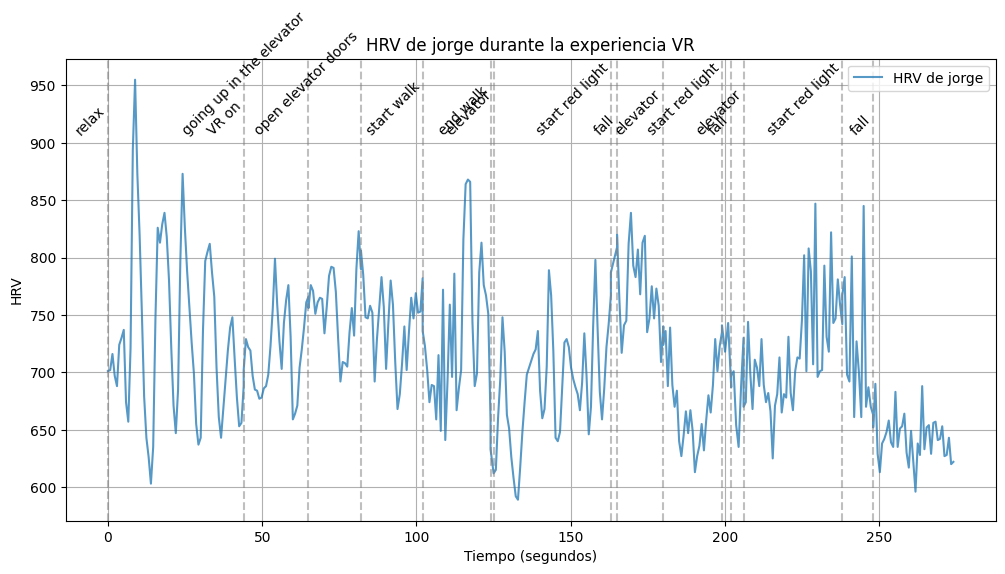

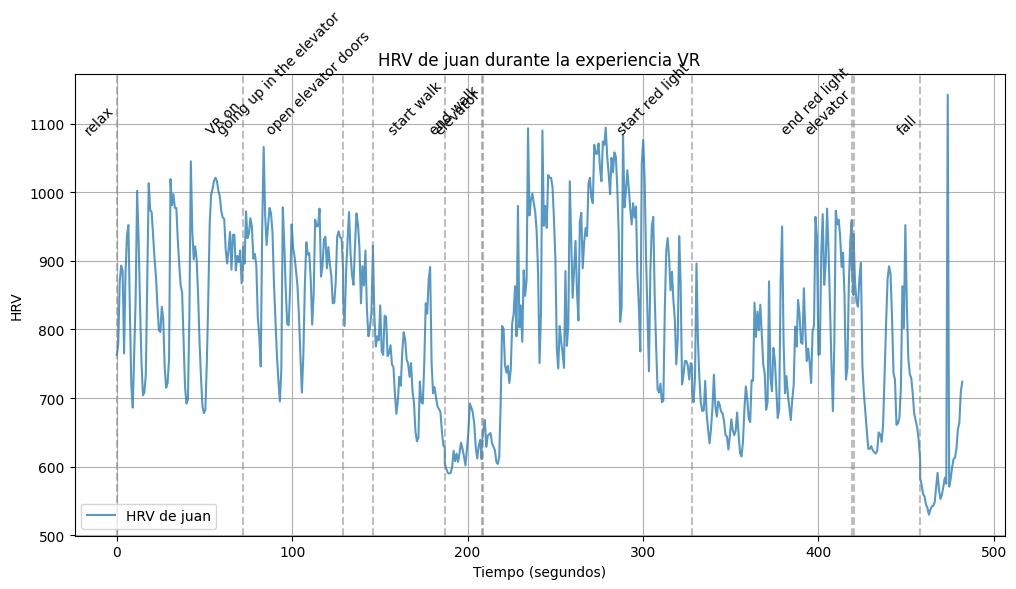

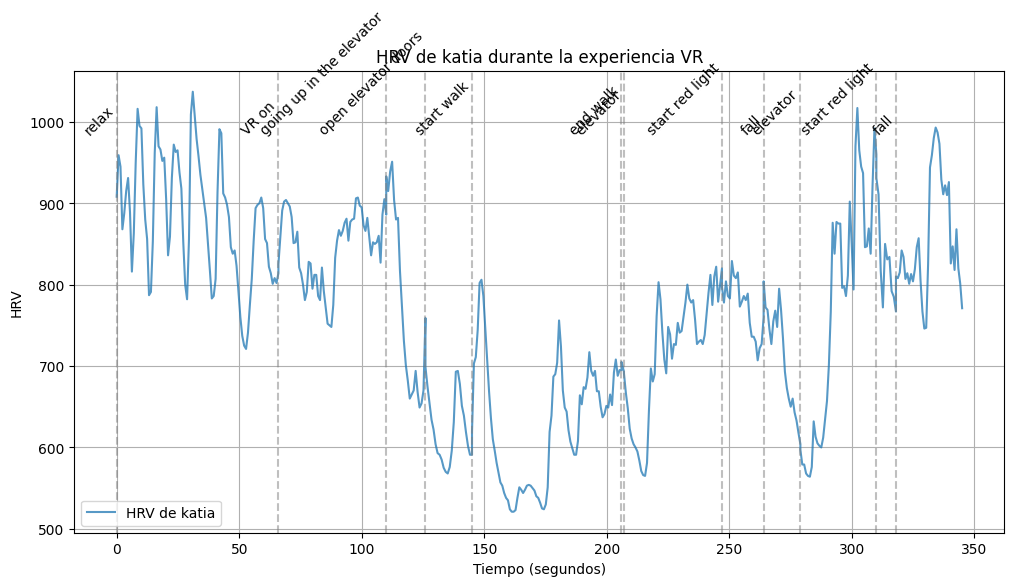

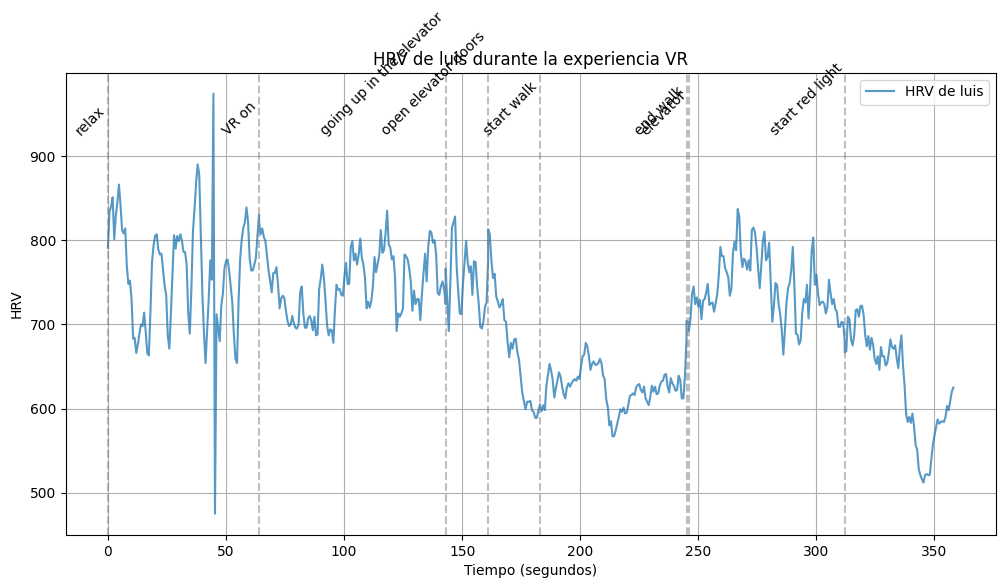

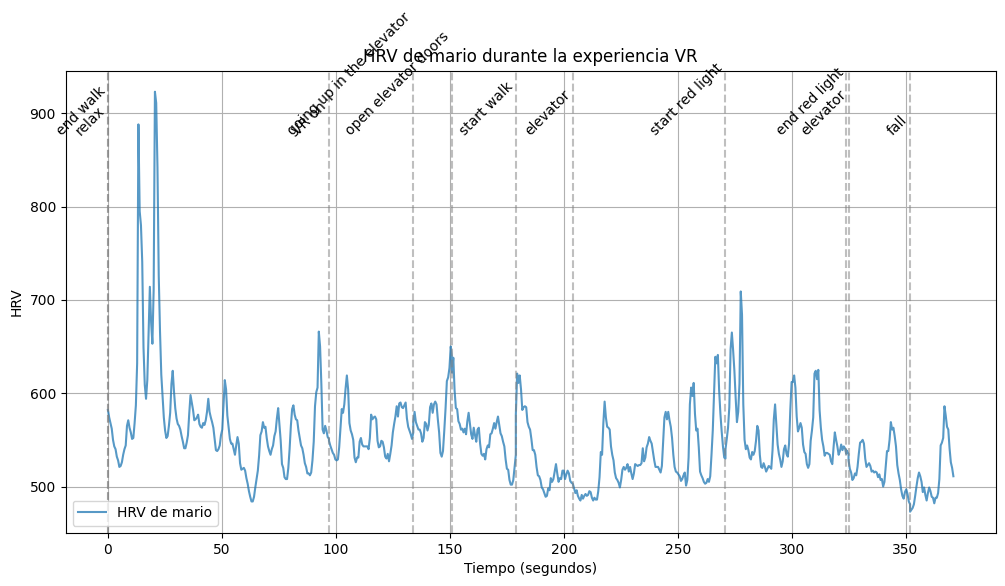

In [32]:
import matplotlib.pyplot as plt

def plot_hrv_with_events(events_df):
    for participant_id in events_df["Nombre"].unique():
        participant_data = events_df[events_df["Nombre"] == participant_id]

        # Crear figura
        plt.figure(figsize=(12, 6))

        hrv_values = []
        time_values = []
        event_labels = []

        for _, row in participant_data.iterrows():
            start_time = row["Tiempo_Inicio"]
            end_time = row["Tiempo_Fin"]
            event_hrv = row["HRV_Muestras"]
            
            # Generar valores de tiempo para cada muestra de HRV dentro del rango del evento
            event_time_values = np.linspace(start_time, end_time, len(event_hrv))
            time_values.extend(event_time_values)
            hrv_values.extend(event_hrv)
            
            # Guardar el evento en la lista si hay un cambio
            if len(event_labels) == 0 or event_labels[-1][1] != row["Evento"]:
                event_labels.append((start_time, row["Evento"]))

        # Graficar HRV
        plt.plot(time_values, hrv_values, label=f"HRV de {participant_id}", alpha=0.75)

        # Etiquetas de eventos
        for event_time, event_name in event_labels:
            plt.axvline(x=event_time, color="gray", linestyle="--", alpha=0.5)
            plt.text(event_time, max(hrv_values) * 0.95, event_name, rotation=45, ha="right", fontsize=10)

        plt.title(f"HRV de {participant_id} durante la experiencia VR")
        plt.xlabel("Tiempo (segundos)")
        plt.ylabel("HRV")
        plt.legend()
        plt.grid()

        plt.show()

# Llamar a la función para graficar
plot_hrv_with_events(events_df)


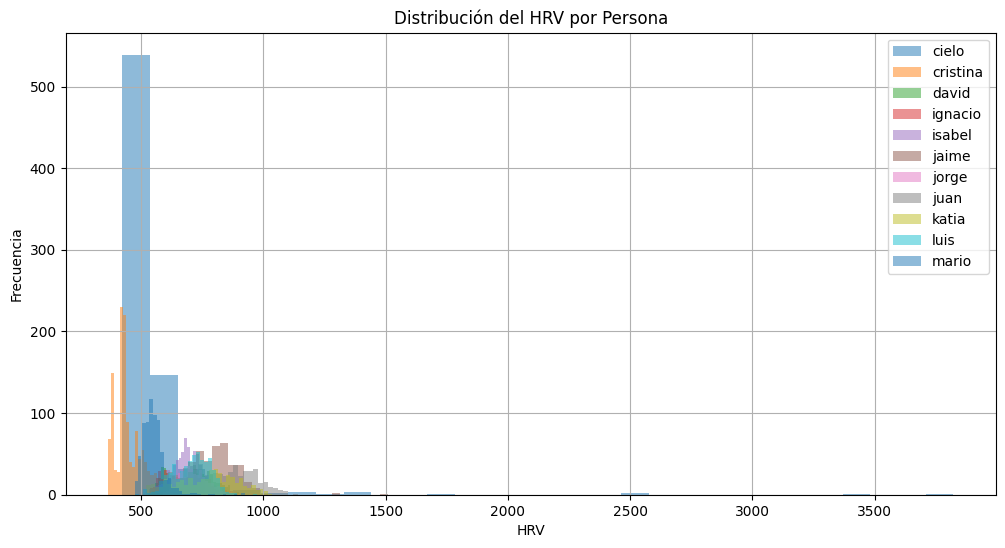

In [33]:
import matplotlib.pyplot as plt

def plot_hrv_histograms_by_person(events_df, bins=30):
    """
    Genera histogramas del HRV para cada persona.
    """
    persons_df = events_df.explode("HRV_Muestras")  # Expandir la lista de muestras
    persons_df["HRV_Muestras"] = pd.to_numeric(persons_df["HRV_Muestras"], errors='coerce')  # Asegurar tipo numérico

    unique_persons = sorted(persons_df["Nombre"].unique())

    plt.figure(figsize=(12, 6))
    
    for person in unique_persons:
        subset = persons_df[persons_df["Nombre"] == person]["HRV_Muestras"].dropna()
        plt.hist(subset, bins=bins, alpha=0.5, label=person)

    plt.title("Distribución del HRV por Persona")
    plt.xlabel("HRV")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid()

    plt.show()

# Generar los histogramas
plot_hrv_histograms_by_person(events_df)


<Figure size 1200x600 with 0 Axes>

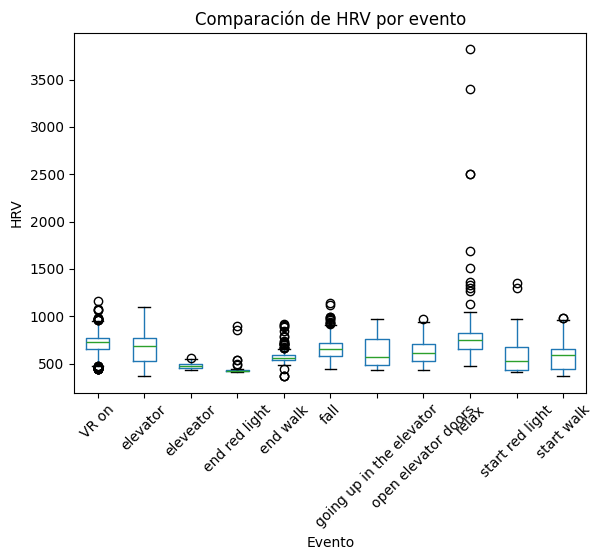

In [34]:
if not events_df.empty:
    # Expandir las muestras de HRV en filas para mejor visualización
    expanded_rows = []
    for _, row in events_df.iterrows():
        for hrv_value in row["HRV_Muestras"]:
            expanded_rows.append({
                "Nombre": row["Nombre"],
                "Evento": row["Evento"],
                "HRV": hrv_value
            })
    
    expanded_df = pd.DataFrame(expanded_rows)
    
    # Crear un boxplot comparando HRV en los distintos eventos
    plt.figure(figsize=(12, 6))
    expanded_df.boxplot(column="HRV", by="Evento", grid=False)
    plt.title("Comparación de HRV por evento")
    plt.suptitle("")
    plt.xlabel("Evento")
    plt.ylabel("HRV")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No hay datos de HRV disponibles para graficar.")

In [36]:
def separate_by_fear_level(events_df, output_file="hrv_por_nivel_miedo.csv"):
    """
    Separa los datos en un nuevo DataFrame basado en 3 niveles de miedo.
    Nivel 1: 0 y 1
    Nivel 2: 2 y 3
    Nivel 3: 4 y 5
    """
    events_df["Nivel_Miedo_Categoria"] = events_df["Nivel_Miedo"].apply(lambda x: 1 if x in [0, 1] else (2 if x in [2, 3] else 3))
    
    fear_levels_df = events_df.explode("HRV_Muestras")  # Expandir la lista de muestras
    fear_levels_df["HRV_Muestras"] = pd.to_numeric(fear_levels_df["HRV_Muestras"], errors='coerce')  # Asegurar tipo numérico
    
    # Crear un nuevo DataFrame agrupado por nivel de miedo
    fear_grouped_df = fear_levels_df.groupby("Nivel_Miedo_Categoria").agg({
        "HRV_Muestras": list,  # Mantener todas las muestras por nivel de miedo
        "Nombre": "nunique"  # Número de participantes únicos en cada nivel de miedo
    }).reset_index()

    fear_grouped_df.columns = ["Nivel_Miedo_Categoria", "HRV_Muestras", "Participantes"]
    
    # Guardar en CSV
    fear_grouped_df.to_csv(output_file, index=False)
    print(f"Datos guardados en {output_file}")
    
    return fear_grouped_df

# Generar el DataFrame separado por nivel de miedo
fear_df = separate_by_fear_level(events_df)


Datos guardados en hrv_por_nivel_miedo.csv



Random Forest Results:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       1.00      0.33      0.50         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2

    accuracy                           0.52        23
   macro avg       0.34      0.21      0.24        23
weighted avg       0.58      0.52      0.53        23



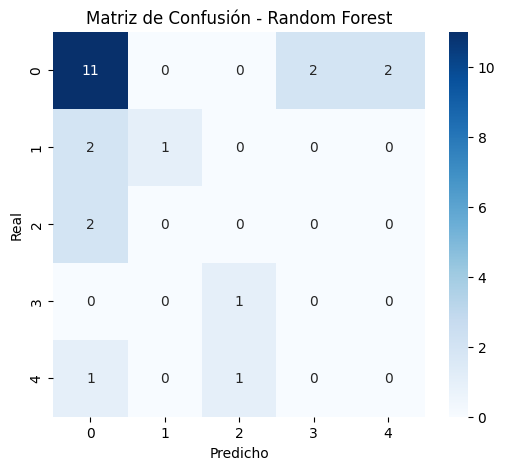


SVM Results:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2

    accuracy                           0.65        23
   macro avg       0.13      0.20      0.16        23
weighted avg       0.43      0.65      0.51        23



C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

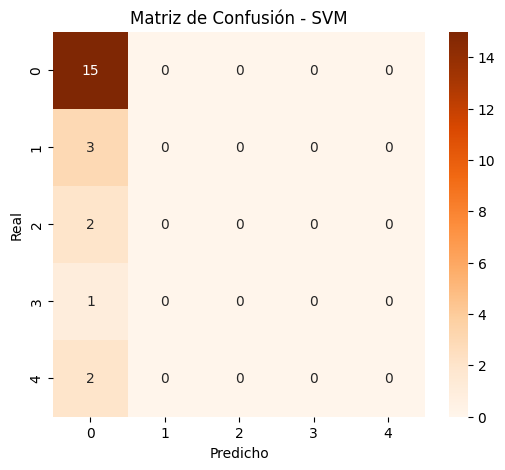

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Cargar el DataFrame
df = pd.read_csv("eventos_hrv.csv")  # Ajusta el nombre del archivo si es necesario

# Extraer características de HRV
def extract_features(hrv_series):
    """ Extrae características estadísticas de HRV, manejando listas vacías """
    if len(hrv_series) == 0:
        return {
            "HRV_Mean": np.nan,
            "HRV_Std": np.nan,
            "HRV_Median": np.nan,
            "HRV_IQR": np.nan,
            "HRV_Max": np.nan,
            "HRV_Min": np.nan
        }
    return {
        "HRV_Mean": np.mean(hrv_series),
        "HRV_Std": np.std(hrv_series),
        "HRV_Median": np.median(hrv_series),
        "HRV_IQR": np.percentile(hrv_series, 75) - np.percentile(hrv_series, 25),
        "HRV_Max": np.max(hrv_series),
        "HRV_Min": np.min(hrv_series)
    }

# Expandir las muestras y extraer características
df["HRV_Muestras"] = df["HRV_Muestras"].apply(eval)  # Convertir de string a lista
features = df["HRV_Muestras"].apply(extract_features).apply(pd.Series)

# Combinar con el nivel de miedo
df_features = pd.concat([features, df["Nivel_Miedo"]], axis=1)

# Eliminar filas con valores NaN generados por listas vacías
df_features = df_features.dropna()

# Verificar cantidad de instancias por clase
class_counts = df_features["Nivel_Miedo"].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df_features = df_features[df_features["Nivel_Miedo"].isin(valid_classes)]

# Dividir en entrenamiento y prueba
X = df_features.drop(columns=["Nivel_Miedo"])
y = df_features["Nivel_Miedo"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modelo 1: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))

# Matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Modelo 2: Support Vector Machine (SVM)
svm_model = SVC(kernel="rbf", C=1, gamma="scale")
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("\nSVM Results:")
print(classification_report(y_test, y_pred_svm))

# Matriz de confusión SVM
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d", cmap="Oranges")
plt.title("Matriz de Confusión - SVM")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()



In [43]:
%pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [44]:

from imblearn.over_sampling import SMOTE


# Verificar cantidad de instancias por clase
class_counts = df_features["Nivel_Miedo"].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df_features = df_features[df_features["Nivel_Miedo"].isin(valid_classes)]

# Dividir en entrenamiento y prueba
X = df_features.drop(columns=["Nivel_Miedo"])
y = df_features["Nivel_Miedo"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar SMOTE para balancear clases
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Modelo 3: Random Forest con datos balanceados
rf_model_balanced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_rf_balanced = rf_model_balanced.predict(X_test)

print("\nRandom Forest con SMOTE Results:")
print(classification_report(y_test, y_pred_rf_balanced))

# Matriz de confusión Random Forest con SMOTE
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf_balanced), annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusión - Random Forest con SMOTE")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Modelo 4: SVM con datos balanceados
svm_model_balanced = SVC(kernel="rbf", C=1, gamma="scale")
svm_model_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_svm_balanced = svm_model_balanced.predict(X_test)

print("\nSVM con SMOTE Results:")
print(classification_report(y_test, y_pred_svm_balanced))

# Matriz de confusión SVM con SMOTE
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm_balanced), annot=True, fmt="d", cmap="Purples")
plt.title("Matriz de Confusión - SVM con SMOTE")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()


ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 5, n_samples = 5